In [1]:
import numpy as np
import random

def K_means(X:np.ndarray,K:int,threshold:float):
    #初始化
    indset=list(random.sample(range(0,X.shape[0]),K))

    centerset=[]  
    for ind in indset:
        centerset.append(X[ind])
    centerset=np.array(centerset)
    #centerset=np.array([[-5,-5],[7,6],[4,0]])
    newcenterset=np.copy(centerset)
    pred=np.array(np.random.randint(0,K,size=X.shape[0]))
    stable=False
    
    while stable==False:
        # E step
        for i,point in enumerate(X):
            diff=np.linalg.norm(np.expand_dims(point, 0)-centerset,axis=1)
            nn_idx = np.argsort(diff)
            pred[i]=nn_idx[0]
        # M step
        for indvalue in range(len(centerset)):
            indexset=np.where(pred==indvalue)
            
            newcenterset[indvalue]=np.mean(X[indexset],0)
                 
        moves=np.linalg.norm(newcenterset-centerset,axis=1)
        m_ids=np.argsort(moves)
        #print(m_ids[-1])
        if moves[m_ids[-1]]<=threshold:
            stable=True

        centerset=np.copy(newcenterset)
        
    
    return pred,centerset


In [14]:
import numpy as np
import random
import math

def Guass(x:np.ndarray,miu:np.ndarray,sigma:np.ndarray):
    D=x.shape[1]
    c1=np.matmul((x-miu).T,np.linalg.inv(sigma))
    c2=np.matmul(c1,(x-miu))
    #print(sigma,np.linalg.det(sigma),math.pow(abs(np.linalg.det(sigma)),-0.5))
    return math.pow(2*np.pi,-D/2)*math.pow(abs(np.linalg.det(sigma)),-0.5)*np.exp(-0.5*c2)

def GMM(X:np.ndarray,K:int,MAX_MLE_value=-1e10,point_seq=1e-4,mle_seq=1e-5,EMcountMAX=150):
    if X.shape[0]<=X.shape[1]:
        return None
    
    #初始化
    stop=False
    EMcount=0
    X=X.T
    miu=[]
    sigma=[]
    pi=[]
    for _ in range(K):
        tempn=K+3
        
        if tempn <=X.shape[0] or tempn>=X.shape[1]:
            tempn=X.shape[1]-1
        
        tempX=X[:,random.sample(range(0,X.shape[1]),tempn)]
        miu.append(np.expand_dims(np.mean(tempX,axis=1),axis=1))
        sigma.append(np.cov(tempX))
        pi.append(np.random.rand())
    psum=sum(pi)
    for i in range(len(pi)):
        pi[i]=pi[i]/psum
    miu=np.array(miu)
    sigma=np.array(sigma)
    pi=np.array(pi)
    pointnums=X.shape[1]
    probability=np.zeros((pointnums,K))
    
    
    while stop==False:
    #for _ in range(L):
        
        MLE_value=0
        #E step
        for i in range(pointnums):
            x=np.expand_dims(X[:,i],axis=1)
            tempsum=0
            for k in range(K):
                if np.linalg.norm(x-miu[k])<point_seq:#为解决奇点问题
                    tempsum+=pi[k]*Guass(x+point_seq,miu[k],sigma[k])[0][0]
                else:
                    tempsum+=pi[k]*Guass(x,miu[k],sigma[k])[0][0]
            for k in range(K):
                if np.linalg.norm(x-miu[k])<point_seq:#为解决奇点问题
                    probability[i][k]=pi[k]*Guass(x+point_seq,miu[k],sigma[k])[0][0]/tempsum
                else:
                    probability[i][k]=pi[k]*Guass(x,miu[k],sigma[k])[0][0]/tempsum
            MLE_value+=math.log(tempsum)
        
        
            
            
                
        #M step
        for k in range(K):
            N_k=sum(probability[:,k])

    #         for i in range(X.shape[1]):
    #             x=np.expand_dims(X[:,i],axis=1)
            gamaset=np.multiply(X,probability[:,k])
            miu[k]=np.expand_dims(gamaset.sum(axis=1),axis=1)/N_k
            tempsigma=np.zeros((X.shape[0],X.shape[0]))
            for i in range(pointnums):
                x=np.expand_dims(X[:,i],axis=1)
                tempsigma+=probability[i,k]*np.matmul(x-miu[k],(x-miu[k]).T)
            sigma[k]=tempsigma/N_k
            pi[k]=N_k/pointnums
            
        #print(pi,miu)
        EMcount+=1
        if MLE_value>MAX_MLE_value and EMcount<EMcountMAX:
            if np.abs(MLE_value-MAX_MLE_value)<mle_seq:
                stop=True
            MAX_MLE_value=MLE_value
            #print(MAX_MLE_value)
        else:
            stop=True
            
            
        
    pred=np.zeros(pointnums)
    pred=np.random.randint(0,K,size=pointnums)
    for i in range(pointnums):
        temppro=list(probability[i,:])
        pred[i]=int(temppro.index(max(temppro)))
     

    
    return pred,probability
        
        
        
    

In [19]:
import numpy as np
import random
from scipy import spatial
from sklearn.cluster import KMeans


def Spectral_Clusting(X:np.ndarray,K:int,add_knum=5):
    pointnums=X.shape[0]
    W=np.zeros((pointnums,pointnums))
    sigma=1
    knum=K+add_knum
    if knum+1 >=pointnums:
        knum=pointnums-1
    tree = spatial.KDTree(X)
    for i in range(pointnums):
        point=X[i]
        scipy_nn_dis,scipy_nn_idx=tree.query(point,knum+1)
        #近邻的个数若太少会影响聚类效果，太多则计算更复杂
        scipy_nn_idx=scipy_nn_idx[1:]
        scipy_nn_dis=scipy_nn_dis[1:]
        for k in range(len(scipy_nn_idx)):
            j=scipy_nn_idx[k]
            W[j][i]=W[i][j]=np.exp(-(scipy_nn_dis[k]**2)/(2*sigma**2))
            
            
    
    dset=[]
    for i in range(W.shape[0]):
        dset.append(sum(W[i,:]))
    D=np.diag(dset)
    
    L=D-W
    #normailze: D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (np.array(dset) ** (0.5)))
    L=np.dot(np.dot(sqrtDegreeMatrix, L), sqrtDegreeMatrix)
    
    e_vals,e_vecs = np.linalg.eig(L)
    
    sorted_indices = np.argsort(e_vals)
    V=e_vecs[:,sorted_indices[:K]]
    
    p,_=K_means(V,K,0.01)
    #p = KMeans(n_clusters=K).fit_predict(V)
    
    return p
            
        
    

In [ ]:
https://blog.csdn.net/DeniuHe/article/details/102519708

[[ 1.88450442e-03 -5.21377309e-02 -6.53180603e-04]
 [ 1.82706728e-03 -5.05486435e-02 -6.33272544e-04]
 [ 1.73197383e-03 -4.79177360e-02 -6.00312579e-04]
 ...
 [ 1.61442296e-03 -4.46655094e-02 -5.59568740e-04]
 [-4.44192242e-03 -2.38697040e-16  5.29900072e-02]
 [-4.01213152e-03 -1.97719714e-16  4.78628076e-02]]


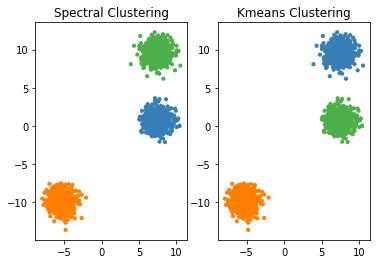

In [271]:

import pandas as pd

import numpy as np

from scipy.spatial.distance import pdist,squareform

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn import datasets

from itertools import cycle,islice

 

def genTwoCircles(n_samples=1000):

    X,y = datasets.make_circles(n_samples,factor=0.5,noise=0.05)

    return X,y

 

def distance(A,B):           #计算两点之间距离   距离计算不一样

    return np.linalg.norm(A-B)

 

def adjacentMatrix_KNN(data,k,sigma=1.0):       #利用KNN获取邻接矩阵

    n = len(data)

    dist_matrix = squareform(pdist(data,metric='euclidean'))

    AdjMat = np.zeros((n,n))

    for i in range(n):

        dist_with_index = zip(dist_matrix[i],range(n))

        dist_with_index = sorted(dist_with_index,key= lambda x:x[0])

        neighbours_id = [dist_with_index[m][1] for m in range(k+1)]

        for j in neighbours_id:

            AdjMat[i,j] = np.exp(-((dist_matrix[i,j])**2)/2/sigma/sigma)

            AdjMat[j,i] = AdjMat[i,j]

    return AdjMat

 

    # '''

    # for idx,each in enumerate(dist_matrix):

    #     index_array = np.argsort(each)

    #     AdjMat[idx][index_array[1:k+1]] = 1

    #     # for i in range(n):

    #     #     for j in range(n):

    #     #         AdjMat[i]

    # AdjMatrix = (AdjMat + AdjMat.T)/2

    # return AdjMatrix

    # '''

 

def LaplacianMatrix(adjacentMatrix):  #获取标准的拉普拉斯矩阵

    # compute the Degree Matrix: D = diag(sum(邻接矩阵))

    degreeMatrix = np.sum(adjacentMatrix,axis=1)

    #计算拉普拉斯矩阵： L= D-A

    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix

    #下面是进行标准化normalize :D^(-1/2) L D^(-1/2)

    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))

    return np.dot(np.dot(sqrtDegreeMatrix,laplacianMatrix),sqrtDegreeMatrix)

 

def getEigVec(LaMat,n_cluster):           #获取k个最小特征值

    eigVal,eigVec = np.linalg.eig(LaMat)

    index_eigVal = np.argsort(eigVal)

    O_index = index_eigVal[0:n_cluster]

    O_eigVec = eigVec[:,O_index]

    return np.real(O_eigVec)

    #return np.real(eigVec)

def plot(X,y_sp,y_km):

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']),int(max(y_km) + 1))))

    plt.subplot(121)

    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_sp])

    plt.title("Spectral Clustering")

    plt.subplot(122)

    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_km])

    plt.title("Kmeans Clustering")

    plt.show()

if __name__ =="__main__":

    #获取数据

    # data1 = np.loadtxt(r'E:\dataset\clusterData\ringData.txt')

    # data2 = np.loadtxt(r'E:\dataset\clusterData\Gaussian.txt')

    # y1 = np.zeros((len(data1),1))

    # y2 = np.ones((len(data2),1))

    # X = np.vstack((data1,data2))  #数据

    # y = np.vstack((y1,y2))        #真实标记

 

    #X,y = genTwoCircles(n_samples=1000)
    X,_=blobs

    k = 3

    A = adjacentMatrix_KNN(X,5,sigma=1.0)

    LapMat = LaplacianMatrix(A)

    H = getEigVec(LapMat,n_cluster=k)
    print(H)

    y_sp = KMeans(n_clusters=k).fit_predict(H)

    y_km = KMeans(n_clusters=k).fit_predict(X)

    plot(X,y_sp,y_km)


In [20]:
class my_Kmeans():
    def __init__(self,K,threshold):
        self.K=K
        self.threshold=threshold
        
    def fit(self,X:np.ndarray):
        pred,centers=K_means(X,self.K,self.threshold)
        return pred
    
class my_GMM():
    def __init__(self,K):
        self.K=K
        
        
    def fit(self,X:np.ndarray):
        pred,probability=GMM(X,self.K)
        return pred

    
class my_Spectral_Clusting():
    def __init__(self,K):
        self.K=K
        
        
    def fit(self,X:np.ndarray):
        pred=Spectral_Clusting(X,self.K)
        return pred

Automatically created module for IPython interactive environment


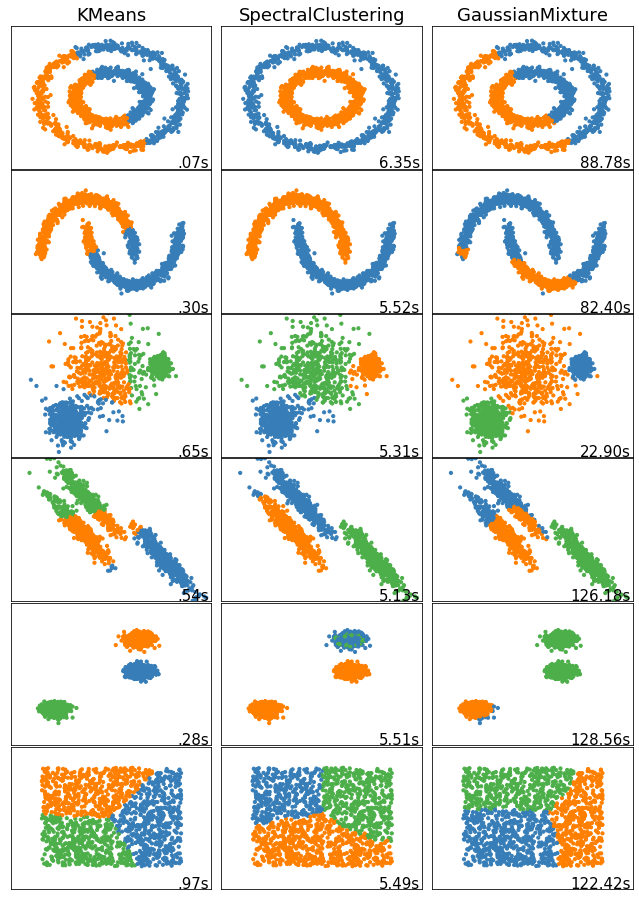

In [18]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(3 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    X=np.array(X)
    
#     # estimate bandwidth for mean shift
#     bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

#     # connectivity matrix for structured Ward
#     connectivity = kneighbors_graph(
#         X, n_neighbors=params['n_neighbors'], include_self=False)
#     # make connectivity symmetric
#     connectivity = 0.5 * (connectivity + connectivity.T)

#     # ============
#     # Create cluster objects
#     # ============
#     ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
#     two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
#     ward = cluster.AgglomerativeClustering(
#         n_clusters=params['n_clusters'], linkage='ward',
#         connectivity=connectivity)
#     spectral = cluster.SpectralClustering(
#         n_clusters=params['n_clusters'], eigen_solver='arpack',
#         affinity="nearest_neighbors")
#     dbscan = cluster.DBSCAN(eps=params['eps'])
#     optics = cluster.OPTICS(min_samples=params['min_samples'],
#                             xi=params['xi'],
#                             min_cluster_size=params['min_cluster_size'])
#     affinity_propagation = cluster.AffinityPropagation(
#         damping=params['damping'], preference=params['preference'])
#     average_linkage = cluster.AgglomerativeClustering(
#         linkage="average", affinity="cityblock",
#         n_clusters=params['n_clusters'], connectivity=connectivity)
#     birch = cluster.Birch(n_clusters=params['n_clusters'])
#     gmm = mixture.GaussianMixture(
#         n_components=params['n_clusters'], covariance_type='full')
    two_means=my_Kmeans(int(params['n_clusters']),0.01)
    gmm=my_GMM(int(params['n_clusters']))
    spectral=my_Spectral_Clusting(int(params['n_clusters']))
    
    clustering_algorithms = (
        ('KMeans', two_means),
        ('SpectralClustering', spectral),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            y_pred=algorithm.fit(X)

        t1 = time.time()
#         if hasattr(algorithm, 'labels_'):
#             y_pred = algorithm.labels_.astype(np.int)
#         else:
#             y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
plt.savefig('C:\\Users\\HUAWEI\\Desktop\\haha.png')
plt.show()
